In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy.stats as stats
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.gridspec as gridspec
import scipy.stats
from scipy.stats import gaussian_kde


/Users/adriennekirk/Desktop/Flash Droughts/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
"""Code for creating histograms with curves for PET, VWC, and Precipation for Ithaca from 2002 - 2025"""

"""Creates a dataframe out of the data with dates, precip, pet, vwc for the columns"""

sdate = '2002-03-01'
edate = '2025-05-31'
lat = 42.45
lon = -76.48

url = f"https://csf-irrigation-api-worker.rcc-acis.workers.dev/vwc/?sdate={sdate}&edate={edate}&lat={lat}&lon={lon}&token=api-4a0607-token"

req = requests.get(url)
data = req.text
# print(data)

data = json.loads(data)
df = pd.DataFrame({
    "date": data["dates"],
    "precip": data["precip"],
    "pet": data["pet"],
    "vwc": data["vwc"]
})
df = df[1::]


In [3]:
""" Creates individual dataframes
    spring: March - May
    summer: june - august
    fall: september - november 
    Puts the dtaes into datetime """

df['date'] = pd.to_datetime(df['date'])
spring = df[(df['date'].dt.month < 6) & (df['date'].dt.month > 2)]
summer = df[(df['date'].dt.month < 9) & (df['date'].dt.month > 5)]
fall = df[(df['date'].dt.month < 11) & (df['date'].dt.month > 8)]
spring['pet'] = spring['pet'].astype(float) * 25.4 #converts to mm
summer['pet'] = summer['pet'].astype(float) * 25.4 #converts to mm
fall['pet'] = fall['pet'].astype(float) * 25.4 #converts to mm

/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/3311252620.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring['pet'] = spring['pet'].astype(float) * 25.4 #converts to mm
/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/3311252620.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer['pet'] = summer['pet'].astype(float) * 25.4 #converts to mm
/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/3311252620.py:13: SettingWithCopyWarning: 
A value is t

In [4]:
"""Sets spring date to the index"""

spring = spring.set_index('date')

In [5]:
""" Creates a spring dataframe
    index: date biweekly starting on a tuesday 
    PET: summed over that week
    Precip: summed over that week
    VWC: value from the last day of that week
    dates of monday: used to find the VWC value """

spring_original = spring.copy()
spring.index = spring.index - pd.to_timedelta((spring.index.dayofweek - 1) % 7, unit='D')
spring_weekly_pet = spring['pet'].groupby(spring.index).sum()
spring_weekly_precip = spring['precip'].groupby(spring.index).sum()
spring_joint_pet_precip = pd.concat([spring_weekly_pet, spring_weekly_precip], axis=1)
spring_joint = pd.concat([spring_joint_pet_precip, spring['vwc']], axis=1)
spring_joint['dates of Monday'] = spring_original.index
spring_weekly = spring_joint[spring_joint['dates of Monday'].dt.dayofweek == 0]
print(spring_weekly)

                  pet    precip   vwc dates of Monday
date                                                 
2002-02-26   2.429220  0.130035  0.29      2002-03-04
2002-03-05   5.829654  0.280029  0.29      2002-03-11
2002-03-12   6.462720  0.130005  0.27      2002-03-18
2002-03-19   4.734120  0.510094  0.28      2002-03-25
2002-03-26   9.051708  1.010132  0.26      2002-04-01
...               ...       ...   ...             ...
2025-04-22  16.176738  0.309975  0.23      2025-04-28
2025-04-29  17.623108  1.639893  0.29      2025-05-05
2025-05-06  14.867873  1.839897  0.25      2025-05-12
2025-05-13  17.095660      0.75  0.26      2025-05-19
2025-05-20  10.685815  1.220032  0.29      2025-05-26

[315 rows x 4 columns]


In [6]:
"""Cleans up the precip as there was a random outlier"""

spring_weekly_clean = spring_weekly[spring_weekly["precip"] >= 0]


Text(0.5, 0.92, 'Spring')

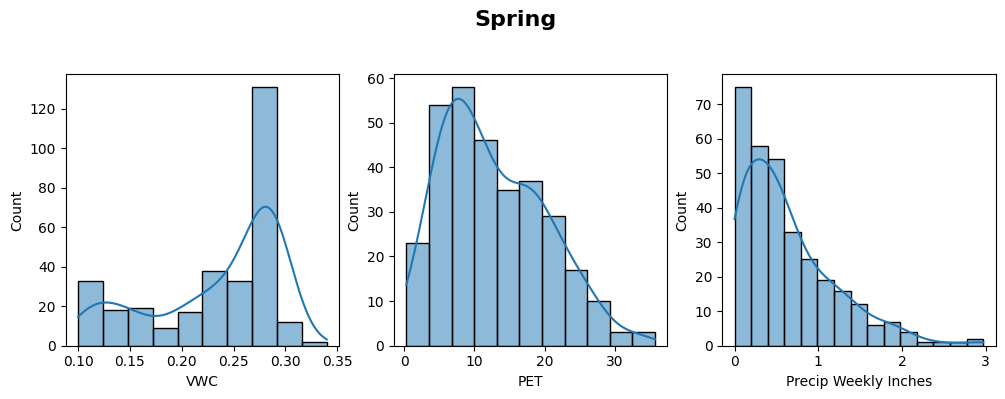

In [7]:
""" Spring:
    Creates histograms overlayed with a kernel density plot for VWC, PET, Precip"""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(spring_weekly, x="vwc", kde=True, ax=ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(spring_weekly, x="pet", kde=True, ax=ax2)
ax2.set_xlabel("PET")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(spring_weekly_clean, x="precip", kde=True, ax=ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Spring', ha='center', fontsize=16, weight='bold')


In [8]:
"""Sets summer date to the index"""

summer = summer.set_index('date')

In [9]:
""" Creates a summer dataframe
    index: date biweekly starting on a tuesday 
    PET: summed over that week
    Precip: summed over that week
    VWC: value from the last day of that week
    dates of monday: used to find the VWC value """

summer_original = summer.copy()
summer.index = summer.index - pd.to_timedelta((summer.index.dayofweek - 1) % 7, unit='D')
summer_weekly_pet = summer['pet'].groupby(summer.index).sum()
summer_weekly_precip = summer['precip'].groupby(summer.index).sum()
summer_joint_pet_precip = pd.concat([summer_weekly_pet, summer_weekly_precip], axis=1)
summer_joint = pd.concat([summer_joint_pet_precip, summer['vwc']], axis=1)
summer_joint['dates of Monday'] = summer_original.index
summer_weekly = summer_joint[summer_joint['dates of Monday'].dt.dayofweek == 0]
print(summer_weekly)

                  pet    precip   vwc dates of Monday
date                                                 
2002-05-28   9.826589  0.370117  0.18      2002-06-03
2002-06-04  20.642108  2.420288  0.21      2002-06-10
2002-06-11  18.095126  2.670105  0.29      2002-06-17
2002-06-18  29.891277  0.189941  0.13      2002-06-24
2002-06-25  26.770298  1.760254  0.21      2002-07-01
...               ...       ...   ...             ...
2024-07-23  27.626186  2.050049  0.19      2024-07-29
2024-07-30  23.992526  2.690155  0.27      2024-08-05
2024-08-06  16.079630  2.958923  0.29      2024-08-12
2024-08-13  20.279583   0.72995  0.28      2024-08-19
2024-08-20  18.189310  0.570038   0.2      2024-08-26

[302 rows x 4 columns]


In [10]:
"""Cleans up the precip as there was a random outlier"""

summer_weekly_clean = summer_weekly[summer_weekly["precip"] >= 0]
print(summer_weekly[summer_weekly["precip"] < 0])

                  pet      precip  vwc dates of Monday
date                                                  
2007-06-12  32.770884 -998.989998  0.1      2007-06-18


Text(0.5, 0.92, 'Summer')

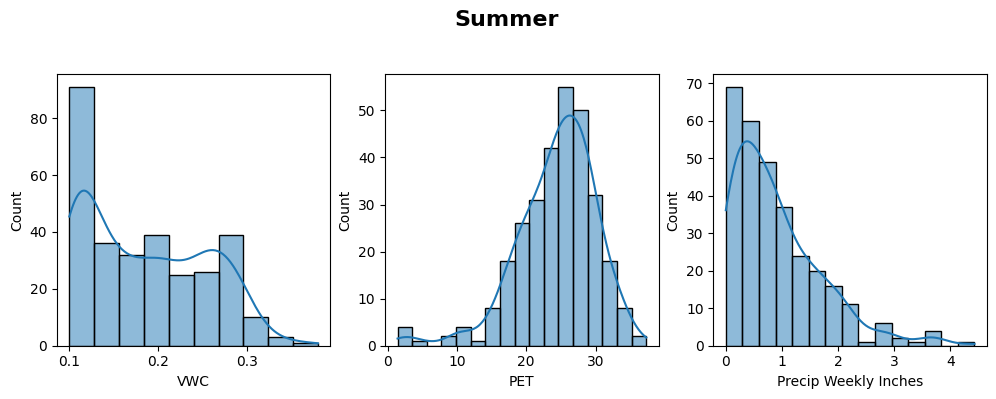

In [11]:
""" Summer: 
    Creates histograms overlayed with a kernel density plot for VWC, PET, Precip"""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(summer_weekly, x="vwc", kde=True, ax=ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(summer_weekly, x="pet", kde=True, ax=ax2)
ax2.set_xlabel("PET")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(summer_weekly_clean, x="precip", kde=True, ax=ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Summer', ha='center', fontsize=16, weight='bold')


In [12]:
"""Sets fall date to the index"""
fall = fall.set_index('date')

In [13]:
""" Creates a fall dataframe
    index: date biweekly starting on a tuesday 
    PET: summed over that week
    Precip: summed over that week
    VWC: value from the last day of that week
    dates of monday: used to find the VWC value """

fall_original = fall.copy()
fall.index = fall.index - pd.to_timedelta((fall.index.dayofweek - 1) % 7, unit='D')
fall_weekly_pet = fall['pet'].groupby(fall.index).sum()
fall_weekly_precip = fall['precip'].groupby(fall.index).sum()
fall_joint_pet_precip = pd.concat([fall_weekly_pet, fall_weekly_precip], axis=1)
fall_joint = pd.concat([fall_joint_pet_precip, fall['vwc']], axis=1)
fall_joint['dates of Monday'] = fall_original.index
fall_weekly = fall_joint[fall_joint['dates of Monday'].dt.dayofweek == 0]
print(fall_weekly)

                  pet    precip   vwc dates of Monday
date                                                 
2002-08-27   5.536132         0  0.14      2002-09-02
2002-09-03  23.040495         0   0.1      2002-09-09
2002-09-10  19.582941         2  0.36      2002-09-16
2002-09-17  14.454479  1.199585   0.3      2002-09-23
2002-09-24  13.081307  1.629639  0.27      2002-09-30
...               ...       ...   ...             ...
2024-09-24   8.108522   0.89006  0.23      2024-09-30
2024-10-01  11.839310  0.259979  0.19      2024-10-07
2024-10-08   7.286768  0.769951  0.28      2024-10-14
2024-10-15   7.990505  0.619934  0.25      2024-10-21
2024-10-22   8.713660   0.05999   0.2      2024-10-28

[201 rows x 4 columns]


In [14]:
"""Cleans up the precip as there was a random outlier"""

fall_weekly_clean = fall_weekly[fall_weekly["precip"] >= 0]

Text(0.5, 0.92, 'Fall')

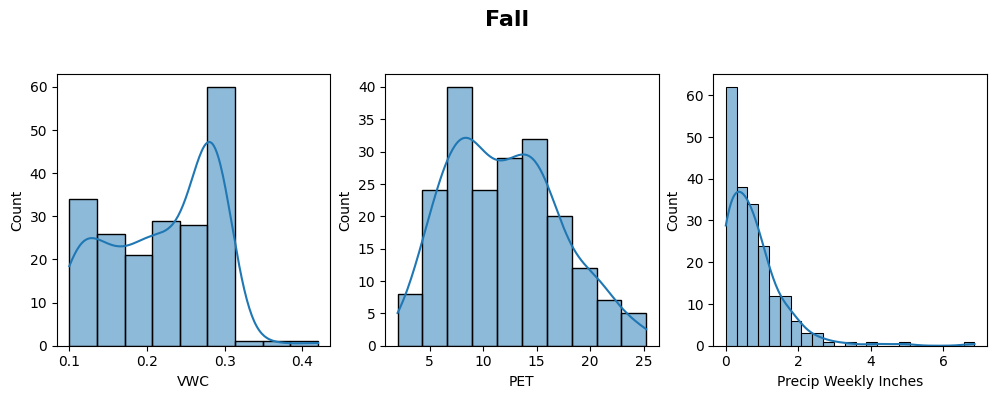

In [15]:
""" Fall:
    Creates histograms overlayed with a kernel density plot for VWC, PET, Precip"""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(fall_weekly, x="vwc", kde=True, ax=ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(fall_weekly, x="pet", kde=True, ax=ax2)
ax2.set_xlabel("PET")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(fall_weekly_clean, x="precip", kde=True, ax=ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Fall', ha='center', fontsize=16, weight='bold')

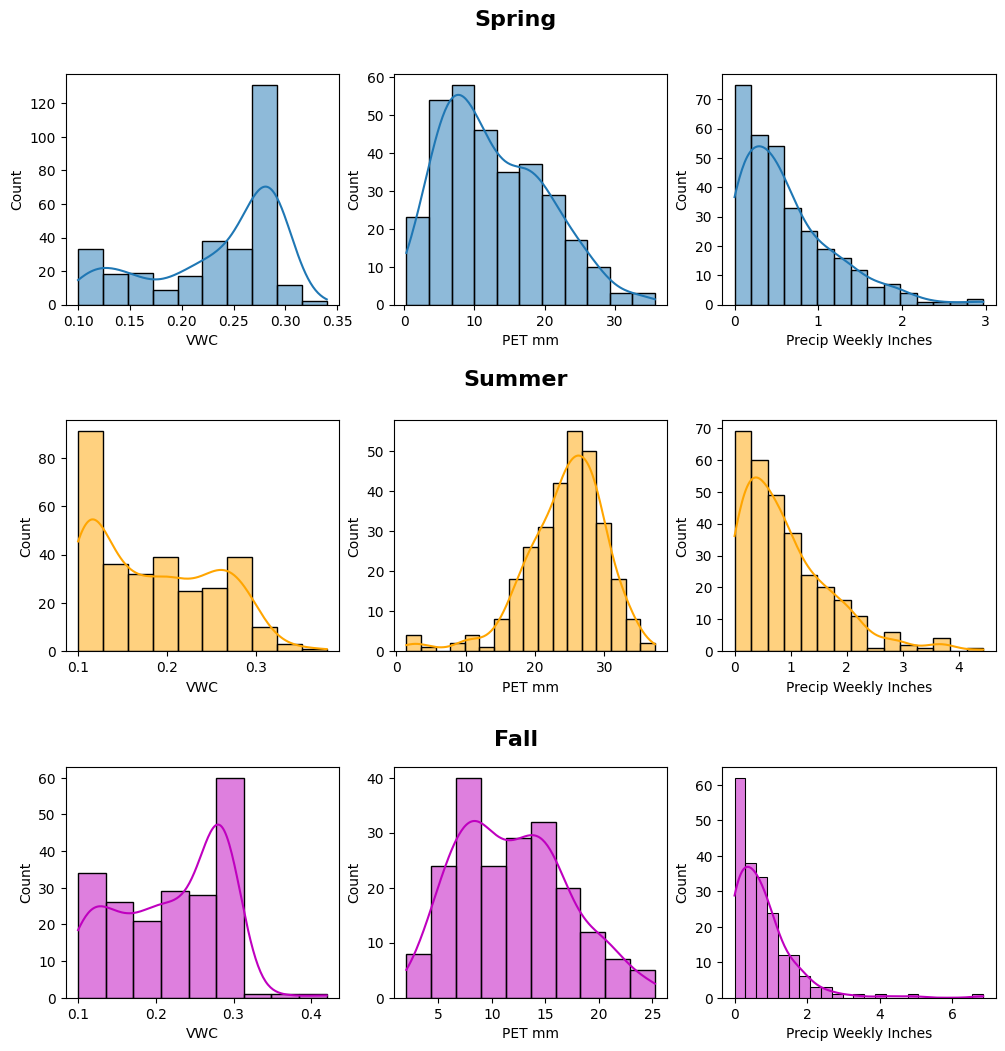

In [16]:
""" Makes 9 graphs putting putting the Spring, Summr and Fall graphs."""

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

# Spring
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(spring_weekly, x = "vwc", kde = True, ax = ax1)
ax1.set_xlabel("VWC")

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(spring_weekly, x = "pet", kde = True, ax = ax2)
ax2.set_xlabel("PET mm")

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(spring_weekly_clean, x = "precip", kde = True, ax = ax3)
ax3.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.92, 'Spring', ha = 'center', fontsize = 16, weight = 'bold')

# Summer
ax4 = fig.add_subplot(gs[1, 0])
sns.histplot(summer_weekly, x = "vwc", color = 'orange', kde = True, ax = ax4)
ax4.set_xlabel("VWC")

ax5 = fig.add_subplot(gs[1, 1])
sns.histplot(summer_weekly, x = "pet", color = 'orange', kde = True, ax = ax5)
ax5.set_xlabel("PET mm")

ax6 = fig.add_subplot(gs[1, 2])
sns.histplot(summer_weekly_clean, x = "precip", color = 'orange', kde = True, ax = ax6)
ax6.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.62, 'Summer', ha = 'center', fontsize = 16, weight = 'bold')

# Fall
ax7 = fig.add_subplot(gs[2, 0])
sns.histplot(fall_weekly, x = "vwc", color = 'm', kde = True, ax = ax7)
ax7.set_xlabel("VWC")

ax8 = fig.add_subplot(gs[2, 1])
sns.histplot(fall_weekly, x = "pet", color = 'm', kde = True, ax = ax8)
ax8.set_xlabel("PET mm")

ax9 = fig.add_subplot(gs[2, 2])
sns.histplot(fall_weekly_clean, x="precip", color = 'm', kde = True, ax = ax9)
ax9.set_xlabel("Precip Weekly Inches")

fig.text(0.5, 0.32, 'Fall', ha = 'center', fontsize = 16, weight = 'bold')
plt.subplots_adjust(hspace = 0.5)
plt.show()



Spring mean:12.712515668404686 and std:7.3317248683450655
Summer mean:23.491035443146405 and std: 6.673701010893461
Fall mean:11.172948280475525 and std:5.51663156727787


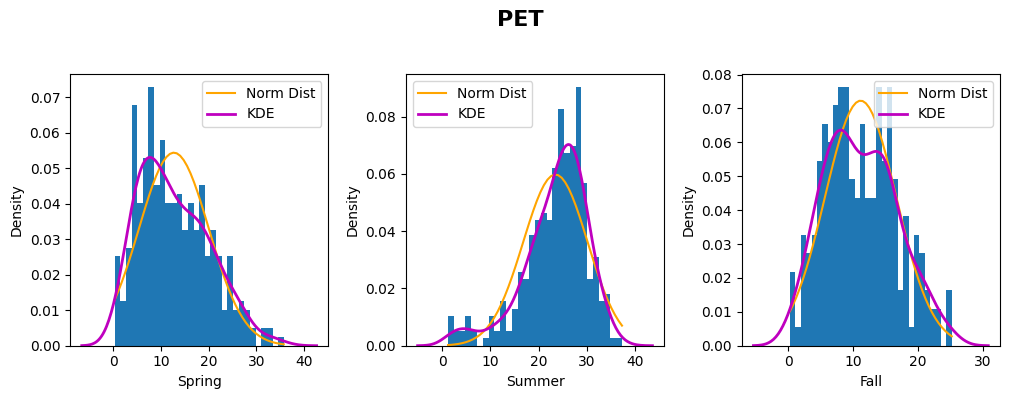

In [17]:
# Normal Fit to ithaca PET Spring, Summer and Fall
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

# Spring
axs1 = fig.add_subplot(gs[0, 0])
spring_weekly_pet_arr = np.array(spring_weekly_pet, dtype=np.float64)
spring_weekly_pet_arr = spring_weekly_pet_arr[np.isfinite(spring_weekly_pet_arr)]
axs1.hist(spring_weekly_pet_arr, bins = 30, density=True)
[sp_mean_fit, sp_std_fit] = scipy.stats.norm.fit(spring_weekly_pet_arr)
sp_x = np.linspace(np.min(spring_weekly_pet_arr), np.max(spring_weekly_pet_arr),)
sp_norm =  scipy.stats.norm.pdf(sp_x, sp_mean_fit, sp_std_fit)
axs1.plot(sp_x, sp_norm, color='orange', label = 'Norm Dist')
sns.kdeplot(spring_weekly_pet_arr, ax=axs1, color='m', linewidth=2, label='KDE')
axs1.set_xlabel("Spring")
axs1.legend()
print(f'Spring mean:{sp_mean_fit} and std:{sp_std_fit}')

# Summer
axs2 = fig.add_subplot(gs[0, 1])
summer_weekly_pet_arr = np.array(summer_weekly_pet, dtype=np.float64)
summer_weekly_pet_arr = summer_weekly_pet_arr[np.isfinite(summer_weekly_pet_arr)]
axs2.hist(summer_weekly_pet_arr,bins = 30, density=True)
sum_mean_fit, sum_std_fit = scipy.stats.norm.fit(summer_weekly_pet_arr)
sum_x = np.linspace(np.min(summer_weekly_pet_arr), np.max(summer_weekly_pet_arr),)
axs2.plot(sum_x, scipy.stats.norm.pdf(sum_x, sum_mean_fit, sum_std_fit), color='orange', label = 'Norm Dist')
sns.kdeplot(summer_weekly_pet_arr, ax=axs2, color='m', linewidth=2, label='KDE')
axs2.set_xlabel("Summer")
axs2.legend()
print(f'Summer mean:{sum_mean_fit} and std: {sum_std_fit}')

# Fall
axs3 = fig.add_subplot(gs[0, 2])
fall_weekly_pet_arr = np.array(fall_weekly_pet, dtype=np.float64)
fall_weekly_pet_arr = fall_weekly_pet_arr[np.isfinite(fall_weekly_pet_arr)]
axs3.hist(fall_weekly_pet_arr, bins = 30, density=True)
fall_mean_fit, fall_std_fit = scipy.stats.norm.fit(fall_weekly_pet_arr)
fall_x = np.linspace(np.min(fall_weekly_pet_arr), np.max(fall_weekly_pet_arr),)
axs3.plot(fall_x, scipy.stats.norm.pdf(fall_x, fall_mean_fit, fall_std_fit), color='orange', label = 'Norm Dist')
sns.kdeplot(fall_weekly_pet_arr, ax=axs3, color='m', linewidth=2, label='KDE')
axs3.set_xlabel("Fall")
axs3.legend()
print(f'Fall mean:{fall_mean_fit} and std:{fall_std_fit}')

fig.text(0.5, 0.92, 'PET', ha = 'center', fontsize = 16, weight = 'bold')
plt.subplots_adjust(wspace = 0.3)


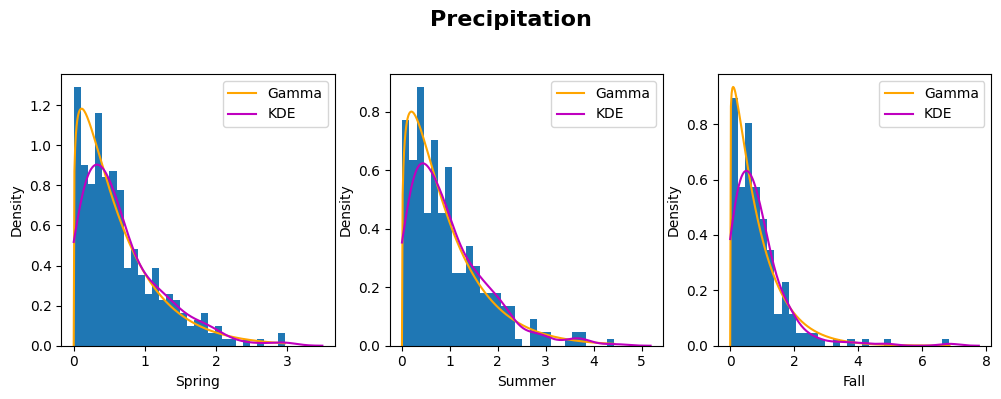

In [18]:
# Precip Gamma Distribution

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

# Spring
axs1 = fig.add_subplot(gs[0, 0])
spring_weekly_precip_arr = np.array(spring_weekly_precip, dtype=np.float64)
spring_weekly_precip_arr = spring_weekly_precip_arr[np.isfinite(spring_weekly_precip_arr)]
spring_weekly_precip_arr = spring_weekly_precip_arr[spring_weekly_precip_arr > 0]
spring_weekly_precip_arr = spring_weekly_precip_arr[spring_weekly_precip_arr < 1000]
axs1.hist(spring_weekly_precip_arr, bins=30, density=True)
[sp_a_fit, sp_loc_fit, sp_scale_fit] = scipy.stats.gamma.fit(spring_weekly_precip_arr, floc=0)
sp_x = np.linspace(0, np.max(spring_weekly_precip_arr),300)
sp_gamma =  scipy.stats.gamma.pdf(sp_x, sp_a_fit, loc = sp_loc_fit, scale = sp_scale_fit)
axs1.plot(sp_x, sp_gamma, color='orange', label = 'Gamma')
sns.kdeplot(spring_weekly_precip_arr, ax=axs1, color='m', label='KDE', clip=(0, None))
axs1.set_xlabel("Spring")
axs1.legend()
fig.text(0.5, 0.92, 'Precipitation', ha = 'center', fontsize = 16, weight = 'bold')

# Summer
axs2 = fig.add_subplot(gs[0, 1])
summer_weekly_precip_arr = np.array(summer_weekly_precip, dtype=np.float64)
summer_weekly_precip_arr = summer_weekly_precip_arr[np.isfinite(summer_weekly_precip_arr)]
summer_weekly_precip_arr = summer_weekly_precip_arr[summer_weekly_precip_arr > 0]
summer_weekly_precip_arr = summer_weekly_precip_arr[summer_weekly_precip_arr < 1000]
axs2.hist(summer_weekly_precip_arr, bins=30, density=True)
[sum_a_fit, sum_loc_fit, sum_scale_fit] = scipy.stats.gamma.fit(summer_weekly_precip_arr, floc=0)
sum_x = np.linspace(0, np.max(summer_weekly_precip_arr),300)
sum_gamma =  scipy.stats.gamma.pdf(sum_x, sum_a_fit, loc = sum_loc_fit, scale = sum_scale_fit)
axs2.plot(sum_x, sum_gamma, color='orange', label = 'Gamma')
sns.kdeplot(summer_weekly_precip_arr, ax=axs2, color='m', label='KDE', clip=(0, None))
axs2.set_xlabel("Summer")
axs2.legend()

# Fall
axs3 = fig.add_subplot(gs[0, 2])
fall_weekly_precip_arr = np.array(fall_weekly_precip, dtype=np.float64)
fall_weekly_precip_arr = fall_weekly_precip_arr[np.isfinite(fall_weekly_precip_arr)]
fall_weekly_precip_arr = fall_weekly_precip_arr[fall_weekly_precip_arr > 0]
fall_weekly_precip_arr = fall_weekly_precip_arr[fall_weekly_precip_arr < 1000]
axs3.hist(fall_weekly_precip_arr, bins=30, density=True)
[fall_a_fit, fall_loc_fit, fall_scale_fit] = scipy.stats.gamma.fit(fall_weekly_precip_arr, floc=0)
fall_x = np.linspace(0, np.max(fall_weekly_precip_arr),300)
fall_gamma =  scipy.stats.gamma.pdf(fall_x, fall_a_fit, loc = fall_loc_fit, scale = fall_scale_fit)
axs3.plot(fall_x, fall_gamma, color='orange', label = 'Gamma')
sns.kdeplot(fall_weekly_precip_arr, ax=axs3, color='m', label='KDE', clip=(0, None))
axs3.set_xlabel("Fall")
axs3.legend()



In [19]:
spring_vwc = spring_weekly['vwc'].dropna()

# def categorize(value, cat0, cat1, cat2, cat3, cat4):
#     if value <= cat0:
#         return 0
#     elif value <= cat1:
#         return 1
#     elif value <= cat2:
#         return 2
#     elif value <= cat3:
#         return 3
#     elif value <= cat4:
#         return 4
#     else:
#         return 5

# def categorize_by_percentile(vwc, p20, p40, p60, p80):
#     if vwc <= p20:
#         return 4
#     elif vwc <= p40:
#         return 3
#     elif vwc <= p60:
#         return 2
#     elif vwc <= p80:
#         return 1
#     else:
#         return 0

# def spring_vwc_categories(zero, first, second, third, fourth):
#     spring_vwc = spring_weekly['vwc'].dropna()
#     cat0 = np.percentile(spring_vwc, zero)
#     cat1 = np.percentile(spring_vwc, first)
#     cat2 = np.percentile(spring_vwc, second)
#     cat3 = np.percentile(spring_vwc, third)
#     cat4 = np.percentile(spring_vwc, fourth)
#     spring_weekly['cat'] = spring_weekly['vwc'].apply(lambda x: categorize_by_percentile(x, cat0, cat1, cat2, cat3) if pd.notna(x) else np.nan)
#     return spring_weekly[['vwc', 'cat']]


# def detect_fast_changes():
#     rate_of_change = spring['cat'].diff(periods=2).abs()
#     mask = rate_of_change >= 2
#     return spring[mask]

In [20]:
def categorize_by_percentile(vwc, p20, p40, p60, p80, p100):
    if vwc <= p20:
        return 4
    elif vwc <= p40:
        return 3
    elif vwc <= p60:
        return 2
    elif vwc <= p80:
        return 1
    else:
        return 0

def spring_vwc_categories(x, zero, first, second, third, fourth):

    cat0 = np.percentile(spring_vwc, zero)
    cat1 = np.percentile(spring_vwc, first)
    cat2 = np.percentile(spring_vwc, second)
    cat3 = np.percentile(spring_vwc, third)
    cat4 = np.percentile(spring_vwc, fourth)

    spring_weekly['cat'] = x.apply(
        lambda x: categorize_by_percentile(x, cat0, cat1, cat2, cat3, cat4) if pd.notna(x) else np.nan
    )

    return spring_weekly[['vwc', 'cat']]

In [21]:
spring = spring_vwc_categories(spring_vwc,60,50,40,30,20)
# print(f"VWC thresholds (dry to wet):")
# print(f"  20th percentile: {cat0:.3f}")
# print(f"  40th percentile: {cat1:.3f}")
# print(f"  60th percentile: {cat2:.3f}")
# print(f"  80th percentile: {cat3:.3f}")
# print(f"  80th percentile: {cat4:.3f}")

/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/887086231.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring_weekly['cat'] = x.apply(


In [22]:
spring['delta_cat'] = spring['cat'].diff(periods=2)
spring[(spring['delta_cat'] <= -2) & (spring['cat'] >= 2)]

/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/2844529542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring['delta_cat'] = spring['cat'].diff(periods=2)


,vwc,cat,delta_cat
date,,,


/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/3405225617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring['delta_cat'] = spring['cat'] - spring['cat'].shift(2)
/var/folders/ys/tnzmyp754gn2yv6qjy8jr8kw0000gn/T/ipykernel_29630/3405225617.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


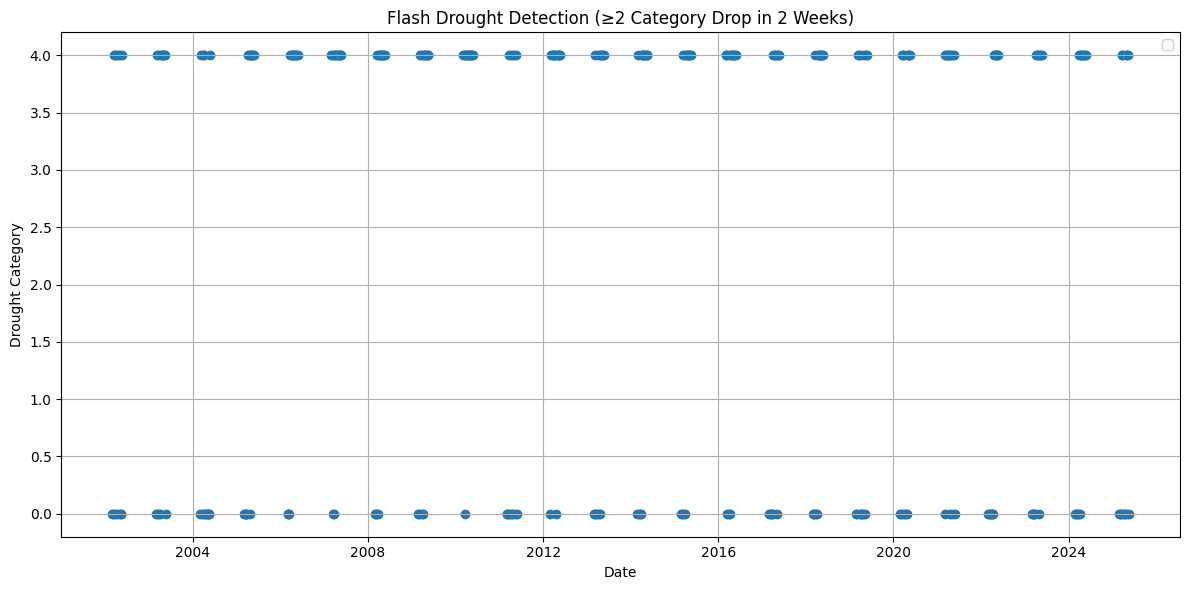

In [23]:
spring['delta_cat'] = spring['cat'] - spring['cat'].shift(2)
flash_drought = spring[(spring['delta_cat'] <= -2)]
plt.figure(figsize=(12, 6))
plt.scatter(spring.index, spring['cat'])
# plt.scatter(flash_drought.index, flash_drought['cat'], color='red', label='Flash Drought Onset', zorder=5)
plt.xlabel('Date')
plt.ylabel('Drought Category')
plt.title('Flash Drought Detection (≥2 Category Drop in 2 Weeks)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Spring VWC')

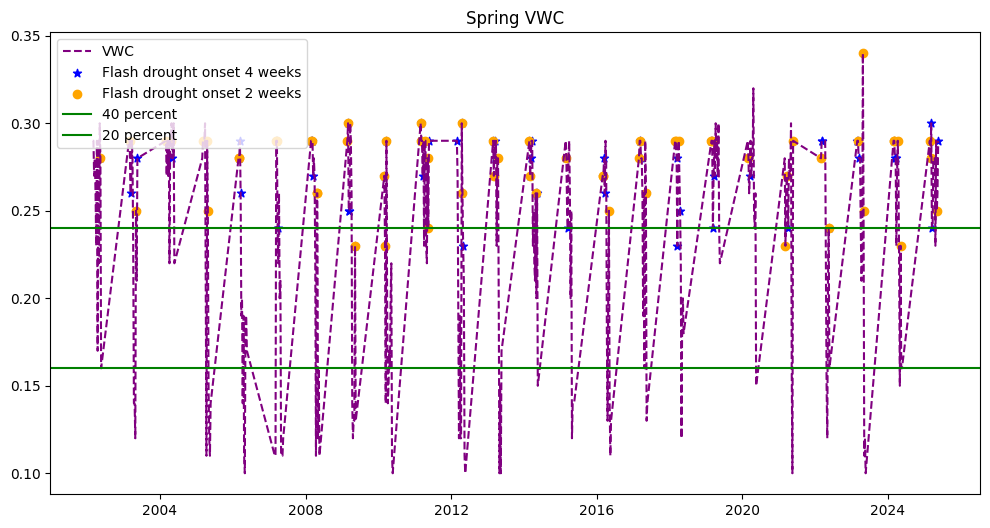

In [24]:

cat0 = np.percentile(spring_vwc, 40)
cat1 = np.percentile(spring_vwc, 38)
cat2 = np.percentile(spring_vwc, 36)
cat3 = np.percentile(spring_vwc, 34)
cat4 = np.percentile(spring_vwc, 32)
def categorize_vwc(vwc):
    if vwc <= cat4:
        return 4
    elif vwc <= cat3:
        return 3
    elif vwc <= cat2:
        return 2
    elif vwc <= cat1:
        return 1
    elif vwc <= cat0:
        return 0
    else:
        return 0
spring_weekly = spring_weekly[spring_weekly['vwc'].notna()]
spring_weekly['cat'] = spring_weekly['vwc'].apply(categorize_vwc)

onsets_four_weeks = []

for i in range(4, len(spring_weekly)):
    cat_now = spring_weekly.iloc[i]['cat']
    cat_past = spring_weekly.iloc[i - 4]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = spring_weekly.index[i]
            vwc_value = spring_weekly.iloc[i]['vwc']
            onsets_four_weeks.append((date, cat_now, vwc_value))
onset_four_weeks = pd.DataFrame(onsets_four_weeks, columns=['onset_date', 'cat', 'vwc'])

onsets_two_weeks = []

for i in range(2, len(spring_weekly)):
    cat_now = spring_weekly.iloc[i]['cat']
    cat_past = spring_weekly.iloc[i - 2]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = spring_weekly.index[i]
            vwc_value = spring_weekly.iloc[i]['vwc']
            onsets_two_weeks.append((date, cat_now, vwc_value))
onset_two_weeks = pd.DataFrame(onsets_two_weeks, columns=['onset_date', 'cat', 'vwc'])
p40 = np.percentile(spring_vwc, 40)
p20 = np.percentile(spring_vwc, 20)
plt.figure(figsize=(12, 6))
plt.plot(spring_weekly.index, spring_weekly['vwc'], color='purple', label='VWC', linestyle='--')
plt.scatter(onset_four_weeks['onset_date'],onset_four_weeks['vwc'], color = 'blue', marker = '*',label = 'Flash drought onset 4 weeks')
plt.scatter(onset_two_weeks['onset_date'],onset_two_weeks['vwc'], color = 'orange', label = 'Flash drought onset 2 weeks')
plt.axhline(p40, color = 'green',label = '40 percent')
plt.axhline(p20, color = 'green', label = '20 percent')
plt.legend(loc = 'upper left')
plt.title('Spring VWC')


Text(0.5, 1.0, 'Summer VWC')

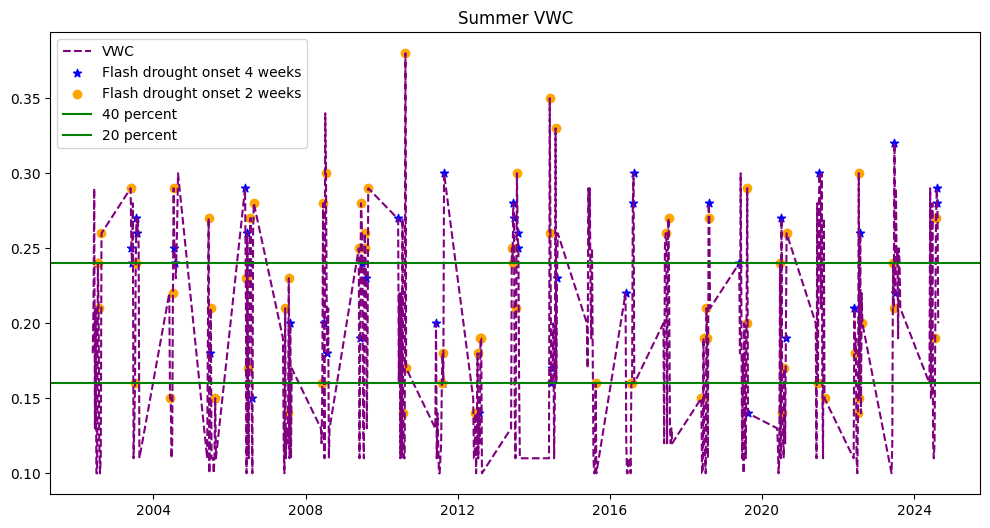

In [25]:
summer_vwc = summer_weekly['vwc']
cat0 = np.percentile(summer_vwc, 40)
cat1 = np.percentile(summer_vwc, 38)
cat2 = np.percentile(summer_vwc, 36)
cat3 = np.percentile(summer_vwc, 34)
cat4 = np.percentile(summer_vwc, 32)
def categorize_vwc(vwc):
    if vwc <= cat4:
        return 4
    elif vwc <= cat3:
        return 3
    elif vwc <= cat2:
        return 2
    elif vwc <= cat1:
        return 1
    elif vwc <= cat0:
        return 0
    else:
        return 0
summer_weekly = summer_weekly[summer_weekly['vwc'].notna()]
summer_weekly['cat'] = summer_weekly['vwc'].apply(categorize_vwc)

onsets_four_weeks = []

for i in range(4, len(summer_weekly)):
    cat_now = summer_weekly.iloc[i]['cat']
    cat_past = summer_weekly.iloc[i - 4]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = summer_weekly.index[i]
            vwc_value = summer_weekly.iloc[i]['vwc']
            onsets_four_weeks.append((date, cat_now, vwc_value))
onset_four_weeks = pd.DataFrame(onsets_four_weeks, columns=['onset_date', 'cat', 'vwc'])

onsets_two_weeks = []

for i in range(2, len(summer_weekly)):
    cat_now = summer_weekly.iloc[i]['cat']
    cat_past = summer_weekly.iloc[i - 2]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = summer_weekly.index[i]
            vwc_value = summer_weekly.iloc[i]['vwc']
            onsets_two_weeks.append((date, cat_now, vwc_value))
onset_two_weeks = pd.DataFrame(onsets_two_weeks, columns=['onset_date', 'cat', 'vwc'])
p40 = np.percentile(spring_vwc, 40)
p20 = np.percentile(spring_vwc, 20)
plt.figure(figsize=(12, 6))
plt.plot(summer_weekly.index, summer_weekly['vwc'], color='purple', label='VWC', linestyle='--')
plt.scatter(onset_four_weeks['onset_date'],onset_four_weeks['vwc'], color = 'blue', marker = '*',label = 'Flash drought onset 4 weeks')
plt.scatter(onset_two_weeks['onset_date'],onset_two_weeks['vwc'], color = 'orange', label = 'Flash drought onset 2 weeks')
plt.axhline(p40, color = 'green',label = '40 percent')
plt.axhline(p20, color = 'green', label = '20 percent')
plt.legend(loc = 'upper left')
plt.title('Summer VWC')

Text(0.5, 1.0, 'Fall VWC')

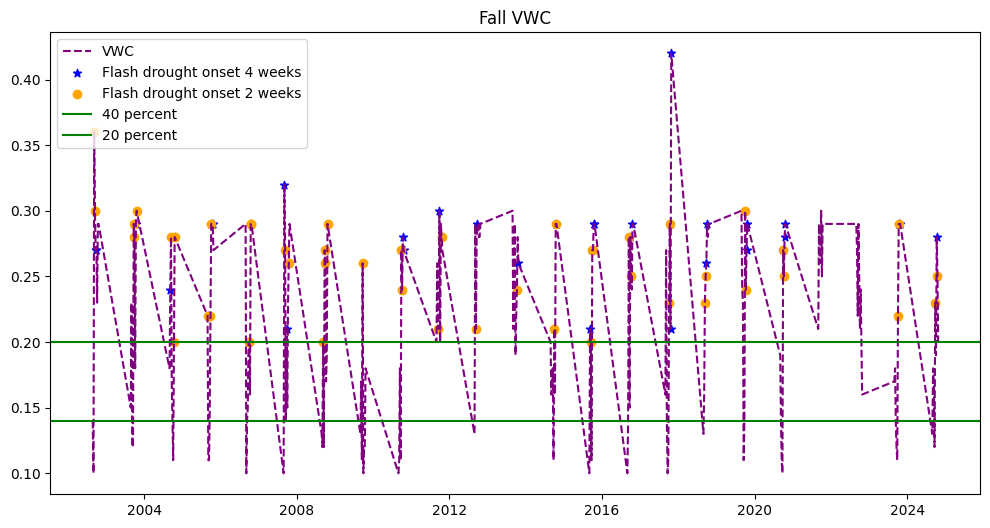

In [26]:
fall_vwc = fall_weekly['vwc']
cat0 = np.percentile(fall_vwc, 40)
cat1 = np.percentile(fall_vwc, 38)
cat2 = np.percentile(fall_vwc, 36)
cat3 = np.percentile(fall_vwc, 34)
cat4 = np.percentile(fall_vwc, 32)
def categorize_vwc(vwc):
    if vwc <= cat4:
        return 4
    elif vwc <= cat3:
        return 3
    elif vwc <= cat2:
        return 2
    elif vwc <= cat1:
        return 1
    elif vwc <= cat0:
        return 0
    else:
        return 0
fall_weekly = fall_weekly[fall_weekly['vwc'].notna()]
fall_weekly['cat'] = fall_weekly['vwc'].apply(categorize_vwc)

onsets_four_weeks = []

for i in range(4, len(fall_weekly)):
    cat_now = fall_weekly.iloc[i]['cat']
    cat_past = fall_weekly.iloc[i - 4]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = fall_weekly.index[i]
            vwc_value = fall_weekly.iloc[i]['vwc']
            onsets_four_weeks.append((date, cat_now, vwc_value))
onset_four_weeks = pd.DataFrame(onsets_four_weeks, columns=['onset_date', 'cat', 'vwc'])

onsets_two_weeks = []

for i in range(2, len(fall_weekly)):
    cat_now = fall_weekly.iloc[i]['cat']
    cat_past = fall_weekly.iloc[i - 2]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = fall_weekly.index[i]
            vwc_value = fall_weekly.iloc[i]['vwc']
            onsets_two_weeks.append((date, cat_now, vwc_value))
onset_two_weeks = pd.DataFrame(onsets_two_weeks, columns=['onset_date', 'cat', 'vwc'])
p40 = np.percentile(fall_vwc, 40)
p20 = np.percentile(fall_vwc, 20)
plt.figure(figsize=(12, 6))
plt.plot(fall_weekly.index, fall_weekly['vwc'], color='purple', label='VWC', linestyle='--')
plt.scatter(onset_four_weeks['onset_date'],onset_four_weeks['vwc'], color = 'blue', marker = '*',label = 'Flash drought onset 4 weeks')
plt.scatter(onset_two_weeks['onset_date'],onset_two_weeks['vwc'], color = 'orange', label = 'Flash drought onset 2 weeks')
plt.axhline(p40, color = 'green',label = '40 percent')
plt.axhline(p20, color = 'green', label = '20 percent')
plt.legend(loc = 'upper left')
plt.title('Fall VWC')

/Users/adriennekirk/Desktop/Flash Droughts/FlashDroughts.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring['pet'] = spring['pet'].astype(float) * 25.4 #converts to mm
/Users/adriennekirk/Desktop/Flash Droughts/FlashDroughts.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer['pet'] = summer['pet'].astype(float) * 25.4 #converts to mm
/Users/adriennekirk/Desktop/Flash Droughts/FlashDroughts.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

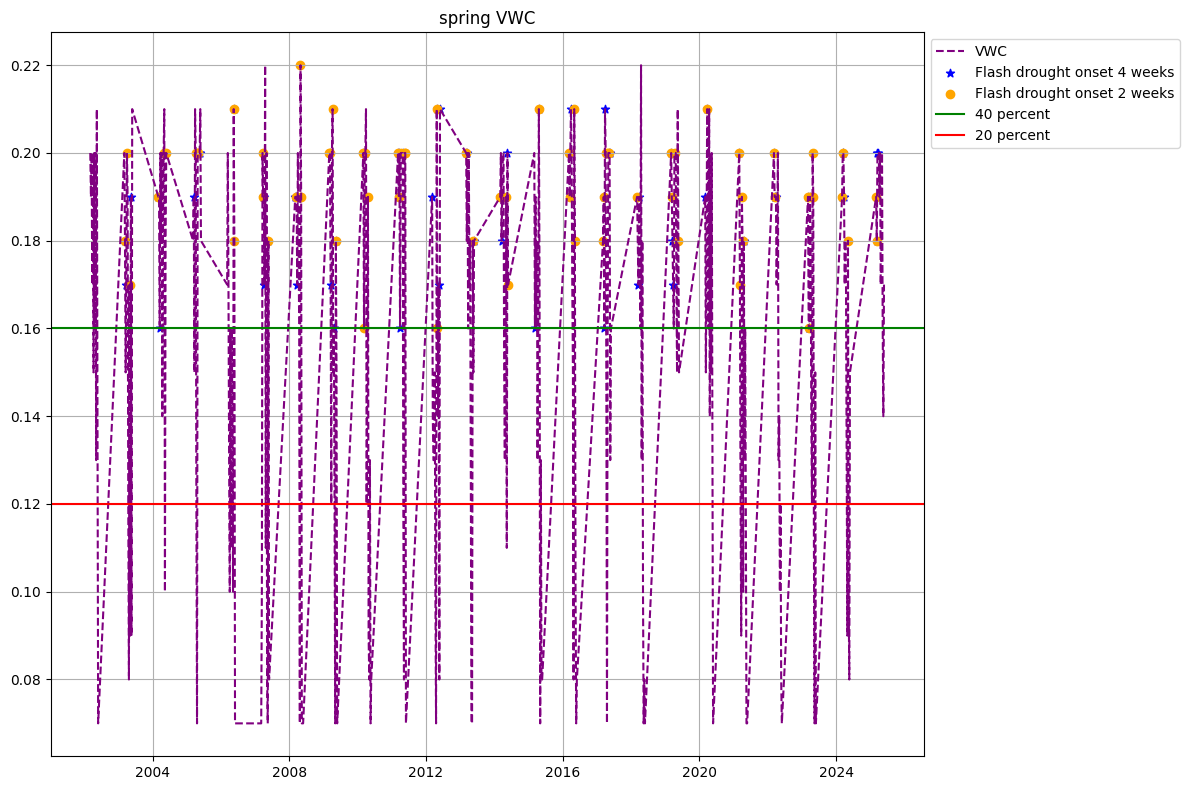

In [27]:
import sys
sys.path.append('/Users/adriennekirk/Desktop/Flash Droughts/')  
from FlashDroughts import KDEhistogram 
from FlashDroughts import vwc

v = vwc(sdate='2002-03-01',
    edate='2025-05-31',
    lat=43.66,
    lon=-70.26)
df = v.categorize_vwc(80,60,40,30,20, 'spring')
onsets4 = v.onset_four_weeks('spring') 
onsets2 = v.onset_two_weeks('spring')
v.vwc_plot('spring')
v.spring
# df.to_csv('IthacaSpring.csv', index=True)

Text(0.5, 1.0, 'Fall PET')

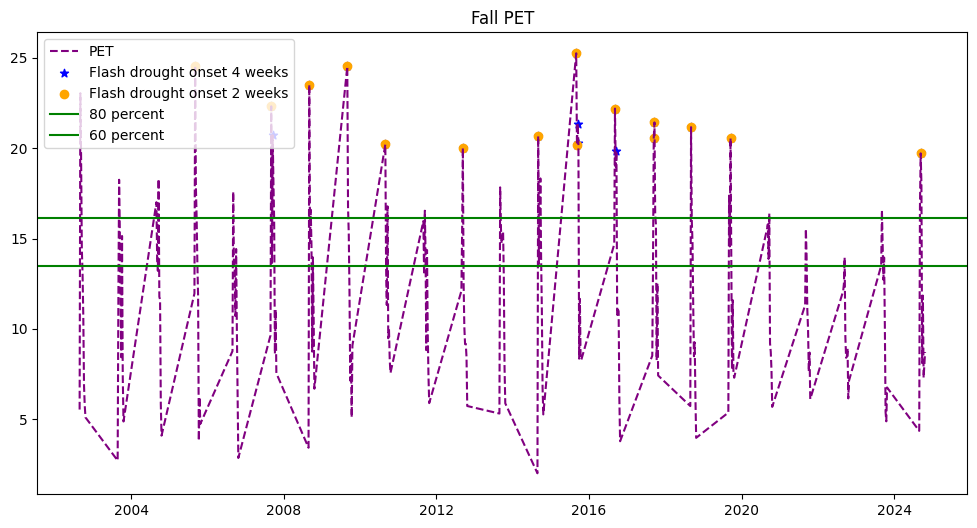

In [31]:
fall_pet = fall_weekly['pet']
cat0 = np.percentile(fall_pet, 60)
cat1 = np.percentile(fall_pet, 70)
cat2 = np.percentile(fall_pet, 80)
cat3 = np.percentile(fall_pet, 85)
cat4 = np.percentile(fall_pet, 90)
def categorize_pet(pet):
    if pet <= cat4:
        return 4
    elif pet <= cat3:
        return 3
    elif pet <= cat2:
        return 2
    elif pet <= cat1:
        return 1
    elif pet <= cat0:
        return 0
    else:
        return 0
fall_weekly = fall_weekly[fall_weekly['pet'].notna()]
fall_weekly['cat'] = fall_weekly['pet'].apply(categorize_pet)

onsets_four_weeks = []

for i in range(4, len(fall_weekly)):
    cat_now = fall_weekly.iloc[i]['cat']
    cat_past = fall_weekly.iloc[i - 4]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = fall_weekly.index[i]
            pet_value = fall_weekly.iloc[i]['pet']
            onsets_four_weeks.append((date, cat_now, pet_value))
onset_four_weeks = pd.DataFrame(onsets_four_weeks, columns=['onset_date', 'cat', 'pet'])

onsets_two_weeks = []

for i in range(2, len(fall_weekly)):
    cat_now = fall_weekly.iloc[i]['cat']
    cat_past = fall_weekly.iloc[i - 2]['cat']

    if pd.notna(cat_now) and pd.notna(cat_past):
        change = cat_now - cat_past

        if change <= -2:  
            date = fall_weekly.index[i]
            pet_value = fall_weekly.iloc[i]['pet']
            onsets_two_weeks.append((date, cat_now, pet_value))
onset_two_weeks = pd.DataFrame(onsets_two_weeks, columns=['onset_date', 'cat', 'pet'])
p60 = np.percentile(fall_pet, 60)
p80 = np.percentile(fall_pet, 80)
plt.figure(figsize=(12, 6))
plt.plot(fall_weekly.index, fall_weekly['pet'], color='purple', label='PET', linestyle='--')
plt.scatter(onset_four_weeks['onset_date'],onset_four_weeks['pet'], color = 'blue', marker = '*',label = 'Flash drought onset 4 weeks')
plt.scatter(onset_two_weeks['onset_date'],onset_two_weeks['pet'], color = 'orange', label = 'Flash drought onset 2 weeks')
plt.axhline(p80, color = 'green',label = '80 percent')
plt.axhline(p60, color = 'green', label = '60 percent')
plt.legend(loc = 'upper left')
plt.title('Fall PET')